In [14]:

!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

--2024-09-17 14:22:42--  https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/5p6kzl0arres80oibztr0/male_female_face_images.zip?rlkey=l2g4hsm5w4z9p4q6vj42mjyr1 [following]
--2024-09-17 14:22:43--  https://www.dropbox.com/scl/fi/5p6kzl0arres80oibztr0/male_female_face_images.zip?rlkey=l2g4hsm5w4z9p4q6vj42mjyr1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc036ea3e544e549c9f495dcdd3c.dl.dropboxusercontent.com/cd/0/inline/CavDD5tCgIRlqsoNqF4oL_IlcUS4GPxljjpI5Fvin38xAKq9Q0H1iB6Ccn6MbtP4rxim2yJPMCHvb5vTlCDAiRIqo-E84Jp4aAj9SzalyYeDR1-8LX5kRuW2XfB-D3DFqMvYhVLg83gt_ZbBjfMlXpiS/file# [following]
--2024-09-17 14:22:44--  https://uc036ea3e544e549c9f4

In [2]:
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', device)

Using device: cuda

In [15]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [17]:
!mkdir cropped_faces
images = Glob('females/*.jpg')+Glob('males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

mkdir: cannot create directory ‘cropped_faces’: File exists


In [7]:
transform = transforms.Compose([transforms.Resize(64), transforms.CenterCrop(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [11]:


class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image
     


In [18]:
ds = Faces(folder='cropped_faces/')

In [19]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Define the Discriminator Architecture
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
        # apply weights
        self.apply(weights_init)
        
    def forward(self, x):
        return self.model(x)

In [23]:
# Discriminator summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [24]:
class Generator(nn.Module):
    def __init__(self):
        
        # Define the Generator Architecture
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
        self.apply(weights_init)
        
    def forward(self, x):
        return self.model(x)

In [25]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [26]:
def discriminatorTrainStep(realData,fakeData):
    d_optimizer.zero_grad()
    predictionReal = discriminator(realData)
    errorReal = loss(predictionReal.squeeze(), torch.ones(len(realData)).to(device))
    errorReal.backward()
    
    predictionFake = discriminator(fakeData)
    errorFake = loss(predictionFake.squeeze(), torch.zeros(len(fakeData)).to(device))
    errorFake.backward()
    
    d_optimizer.step()  
    return errorReal + errorFake

In [27]:
def generatorTrainStep(fakeData):
    g_optimizer.zero_grad()
    prediction = discriminator(fakeData)
    error = loss(prediction.squeeze(), torch.ones(len(fakeData)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [28]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

EPOCH: 1.000  dLoss: 0.611  gLoss: 10.633  (33.81s - 811.50s remaining)
EPOCH: 2.000  dLoss: 0.599  gLoss: 6.145  (66.27s - 762.12s remaining))
EPOCH: 3.000  dLoss: 0.507  gLoss: 5.015  (98.92s - 725.42s remaining))
EPOCH: 4.000  dLoss: 0.527  gLoss: 4.360  (131.69s - 691.36s remaining))
EPOCH: 5.000  dLoss: 0.583  gLoss: 3.821  (164.63s - 658.52s remaining)
EPOCH: 6.000  dLoss: 0.583  gLoss: 3.643  (197.59s - 625.71s remaining)
EPOCH: 7.000  dLoss: 0.610  gLoss: 3.505  (230.57s - 592.90s remaining)
EPOCH: 8.000  dLoss: 0.608  gLoss: 3.277  (263.58s - 560.11s remaining)
EPOCH: 9.000  dLoss: 0.599  gLoss: 3.198  (296.65s - 527.37s remaining)
EPOCH: 10.000  dLoss: 0.576  gLoss: 3.256  (329.74s - 494.62s remaining)
EPOCH: 11.000  dLoss: 0.600  gLoss: 3.246  (362.81s - 461.75s remaining)
EPOCH: 12.000  dLoss: 0.594  gLoss: 3.174  (395.88s - 428.87s remaining)
EPOCH: 13.000  dLoss: 0.489  gLoss: 3.133  (428.94s - 395.95s remaining)
EPOCH: 14.000  dLoss: 0.614  gLoss: 3.098  (462.01s - 363.0

100%|██████████| 126/126 [00:00<00:00, 705.11it/s]


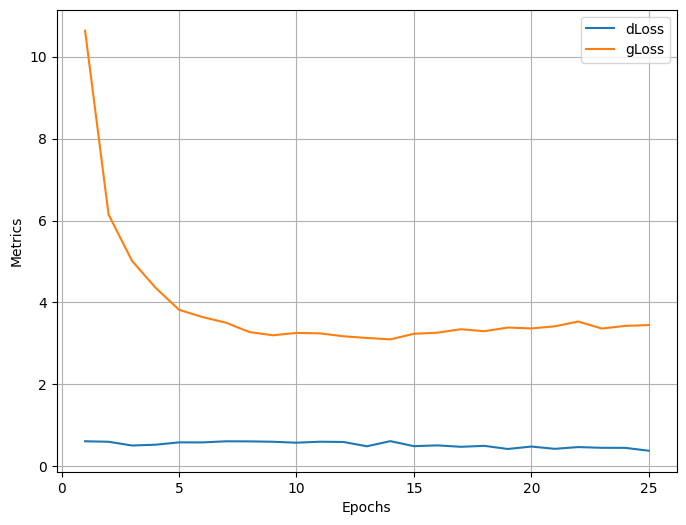

In [29]:
log = Report(25)
for epoch in range(25):
    
    N = len(dataloader)
    for i,images in enumerate(dataloader):
        # real images
        realData = images.to(device)
        
        # Generate Fake images
        fakeData = generator(torch.randn(len(realData), 100, 1, 1).to(device)).to(device)
        fakeData = fakeData.detach()
        
        # Train the Discriminator
        dLoss = discriminatorTrainStep(realData, fakeData)
        
        # Generate Fake images
        fakeData = generator(torch.randn(len(realData), 100, 1, 1).to(device)).to(device)
        gLoss = generatorTrainStep(fakeData)
        
        # Log the loss values
        log.record(epoch+(i+1)/N, dLoss=dLoss.item(), gLoss=gLoss.item(), end='\r')
    log.report_avgs(epoch+1)
    
log.plot_epochs(['dLoss','gLoss'])
        
    

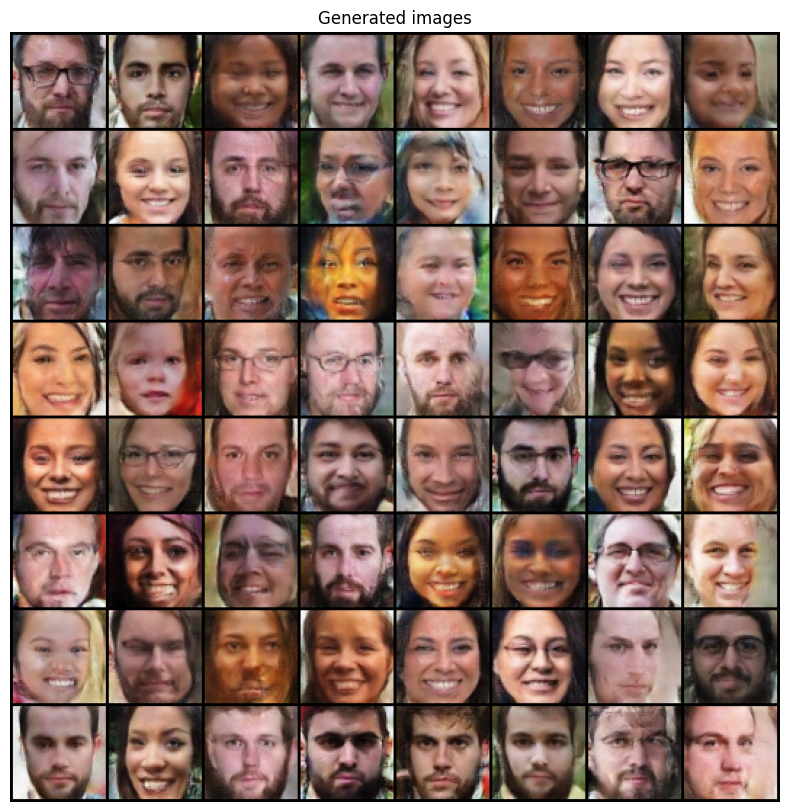

In [47]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')